In [55]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import normaltest

from matplotlib import pyplot as plt
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

# Read in Pickle Containing MLB 2017 Data

In order to perform analyses on my data, I need to read in my pickle file:

In [56]:
df = pd.read_pickle('mlb_sal_stats_17.pkl')

In [57]:
df.head()

,Name,Age,Tm,IP,G,GS,R,RA9,RA9opp,RA9def,...,RAA,WAA,gmLI,WAAadj,WAR,RAR,waaWL%,162WL%,Salary,Acquired
0,Fernando Abad,31,BOS,43.2,48,0,18,3.71,4.78,0.43,...,2,0.2,.68,-0.2,0.5,7,.504,.501,2000000,Traded
1,Matt Albers,34,WSN,61.0,63,0,12,1.77,4.77,-0.11,...,19,2.0,1.10,-0.1,2.5,25,.531,.512,1150000,Free Agency
2,Raul Alcantara,24,OAK,24.0,8,4,21,7.88,4.80,-0.30,...,-7,-0.7,.12,0.1,-0.4,-4,.416,.496,535000,Traded
3,Cody Allen,28,CLE,67.1,69,0,24,3.21,4.78,0.18,...,9,0.9,1.63,0.1,1.7,17,.513,.506,7350000,Amateur Draft
4,Dan Altavilla,24,SEA,46.2,41,0,27,5.21,5.19,0.08,...,-4,-0.4,.73,-0.1,0.0,2,.491,.498,536100,Amateur Draft


In [58]:
df.columns

Index(['Name', 'Age', 'Tm', 'IP', 'G', 'GS', 'R', 'RA9', 'RA9opp', 'RA9def',
       'RA9role', 'PPFp', 'RA9avg', 'RAA', 'WAA', 'gmLI', 'WAAadj', 'WAR',
       'RAR', 'waaWL%', '162WL%', 'Salary', 'Acquired'],
      dtype='object')

Now that I have my data, I want to convert the columns containing numbers from objects to numerical values.

In [59]:
df[['Age', 'IP', 'G', 'GS', 'R', 'RA9', 'RA9opp',
       'RA9def', 'RA9role', 'PPFp', 'RA9avg', 'RAA', 'WAA', 'gmLI', 'WAAadj',
       'WAR', 'RAR', 'waaWL%', '162WL%', 'Salary']]\
 = df[['Age', 'IP', 'G', 'GS', 'R', 'RA9', 'RA9opp',
       'RA9def', 'RA9role', 'PPFp', 'RA9avg', 'RAA', 'WAA', 'gmLI', 'WAAadj',
       'WAR', 'RAR', 'waaWL%', '162WL%', 'Salary']].apply(pd.to_numeric)

In [60]:
df.dtypes

Name         object
Age           int64
Tm           object
IP          float64
G             int64
GS            int64
R             int64
RA9         float64
RA9opp      float64
RA9def      float64
RA9role     float64
PPFp        float64
RA9avg      float64
RAA           int64
WAA         float64
gmLI        float64
WAAadj      float64
WAR         float64
RAR           int64
waaWL%      float64
162WL%      float64
Salary        int64
Acquired     object
dtype: object

Great! Now I have a dataframe with which I can model my target Salary using linear regression.

# Eliminating Outliers

In [61]:
df.IP.min()

0.10000000000000001

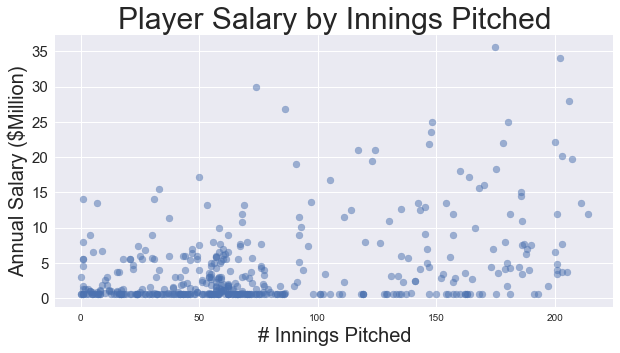

In [62]:
plt.figure(figsize=(10,5))
plt.scatter(df.IP,df.Salary,alpha=.5)
plt.xlabel('# Innings Pitched', size=20)
plt.yticks(np.arange(40000000,step=5000000),(0,5,10,15,20,25,30,35), size=15)
plt.ylabel('Annual Salary ($Million)', size=20)
plt.title('Player Salary by Innings Pitched', size=30);

Hmmmmmm, it looks like we have some players that did not even pitch a full inning. This could mean that pitchers were injured, underutilized, **OR** that position players (non-pitchers) are occassionally pitching and could skew the data. 

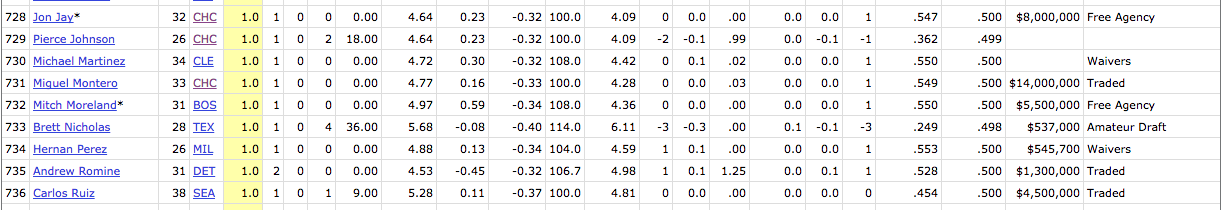

Sure enough, there are players like Jon Jay and Miguel Montero who are position players with high salaries that only pitched for 1 inning. This will obviously skew our data, as we are only interested in pitchers. For this reason, I will remove observations with 4 innings pitched or fewer.

In [63]:
len(df.loc[(df.IP <= 4)])

20

Removing those pitchers that have not pitched very much is an improvement, but I am really just interested in starting pitchers. In that case, I can just remove players that did not start a single game. This might include some relievers who filled in for starters and will certainly include starting pitchers who were injured during the season, but it is an improvement.

In [64]:
df = df.loc[df.GS >= 4]

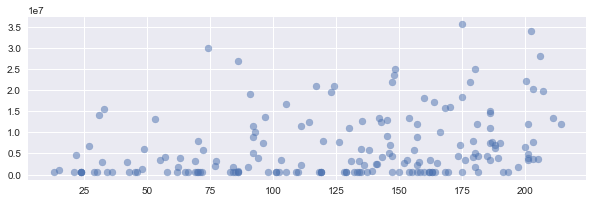

In [65]:
plt.figure(figsize=(10,3))
plt.scatter(df.IP,df.Salary, alpha = .5);

# Visualize Correlation

I can examine potential correlations using scatter plots through Matplotlib and Pandas.

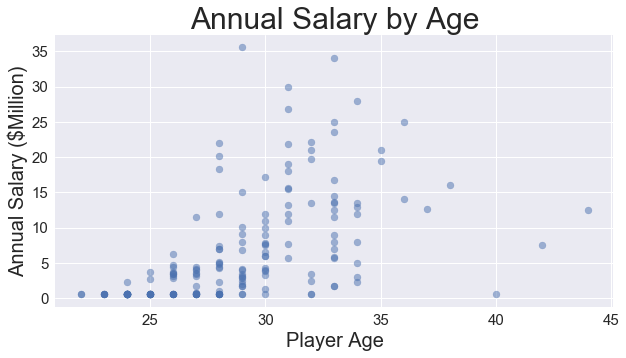

In [66]:
plt.figure(figsize=(10,5))
plt.scatter(df.Age,df.Salary, alpha=.5)
plt.yticks(np.arange(40000000,step=5000000),(0,5,10,15,20,25,30,35), size=15)
plt.xticks(size=15)
plt.xlabel('Player Age', size=20)
plt.ylabel('Annual Salary ($Million)', size=20)
plt.title('Annual Salary by Age', size=30);

# MVP: Salary Based on Age

Run a linear regression of Salary dependent upon Age. The guess here is that Salary increases with Age, for various reasons that I will not exhauast in this cell.

In [67]:
lr_age = LinearRegression()
X = df.loc[:,'Age'].values.reshape(-1,1)
y = df.loc[:,'Salary'].values.reshape(-1,1)
lr_age.fit(X,y)
lr_age.score(X,y)
print('Coefficient Matrix: %s\n Intercept: %s\n R^2: %s'%(lr_age.coef_, lr_age.intercept_, lr_age.score(X,y)))

Coefficient Matrix: [[ 1103499.55124508]]
 Intercept: [-25294882.32614306]
 R^2: 0.312204982507


Great, now that I have my model, I am going to plot it!

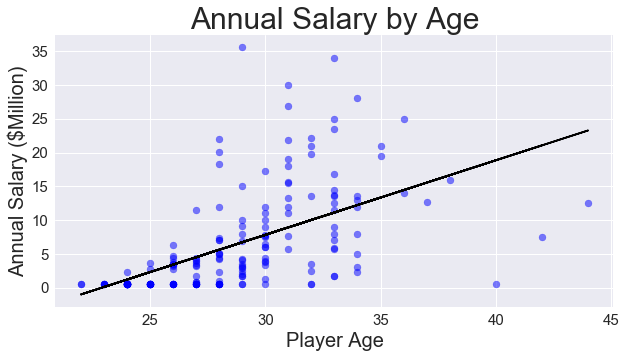

In [71]:
plt.figure(figsize=(10,5))
plt.scatter(X, y, c='b', alpha = .5)
plt.plot(X, lr_age.predict(X), c='k')
plt.yticks(np.arange(40000000,step=5000000),(0,5,10,15,20,25,30,35), size=15)
plt.xticks(size=15)
plt.xlabel('Player Age', size=20)
plt.ylabel('Annual Salary ($Million)', size=20)
plt.title('Annual Salary by Age', size=30);

In [17]:
lr_age = LinearRegression()
X = df.loc[:,'Age'].values.reshape(-1,1)
y = np.log(df.loc[:,'Salary']).values.reshape(-1,1)
lr_age.fit(X,y)
lr_age.score(X,y)
print('Coefficient Matrix: %s\n Intercept: %s\n R^2: %s'%(lr_age.coef_, lr_age.intercept_, lr_age.score(X,y)))

Coefficient Matrix: [[ 0.23993423]]
 Intercept: [ 7.95995608]
 R^2: 0.432100512196


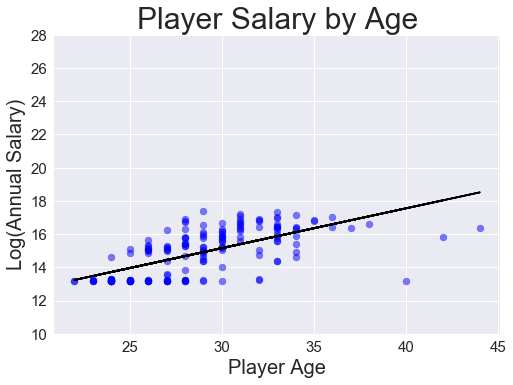

In [18]:
plt.scatter(X, y, c='b', alpha = .5)
plt.plot(X, lr_age.predict(X), c='k')
plt.yticks(np.arange(10,30,step=2),(10,12,14,16,18,20,22,24,26,28,30), size=15)
plt.xticks(size=15)
plt.xlabel('Player Age', size=20)
plt.ylabel('Log(Annual Salary)', size=20)
plt.title('Player Salary by Age', size=30);